## variational autoencoder

In [37]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=200, z_dim=20) -> None:
        super(VAE, self).__init__()
        # ecnoder
        self.in_hid =  nn.Linear(input_dim, hidden_dim)
        self.hid_mean = nn.Linear(hidden_dim, z_dim)
        self.hid_std = nn.Linear(hidden_dim, z_dim)

        #decoder
        self.z_hid = nn.Linear(z_dim, hidden_dim)
        self.hid_out = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.in_hid(x))
        mean = self.hid_mean(h)
        std = self.hid_std(h)
        return mean, std

    def decode(self, x):
        h = self.relu(self.z_hid(x))
        out = self.sigmoid(self.hid_out(h))
        return out

    def forward(self, x):
        mean, std =  self.encode(x)
        epsilon = torch.randn_like(std)
        z_reparam = mean + std*epsilon
        out = self.decode(z_reparam)
        return out, mean, std

In [38]:
vae = VAE(input_dim=784)
x = torch.rand(5,784)
out, mean, std = vae(x)
print(out.shape)

mean, std = vae.encode(x)

torch.Size([5, 784])


## data

In [41]:
import torchvision
import torchvision.transforms as transforms

print(f'CUDA available: {torch.cuda.is_available()}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
input_dim = 28*28
hidden_dim = 200
z_dim = 20
batch_size = 128
epochs = 55


dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, download=False, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

vae = VAE(input_dim=input_dim)


optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss(reduction="sum")

# for visualization later
images = []
idx = 0
for x, y in dataset:
    if y == idx:
        images.append(x)
        idx += 1
    if idx == 10:
        break


CUDA available: True


## train

Epoch 0: loss 19869.85546875


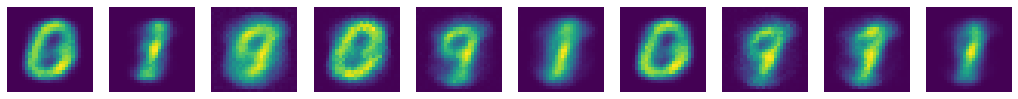

Epoch 5: loss 13514.2509765625


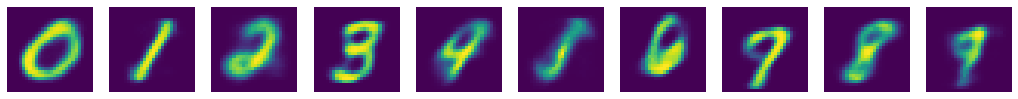

Epoch 10: loss 13460.021484375


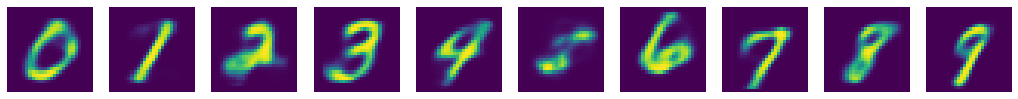

Epoch 15: loss 13020.017578125


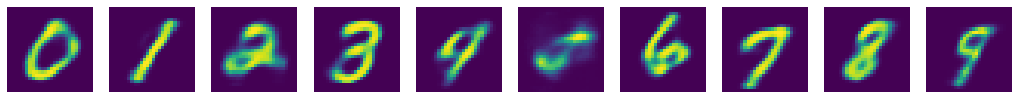

Epoch 20: loss 12711.9541015625


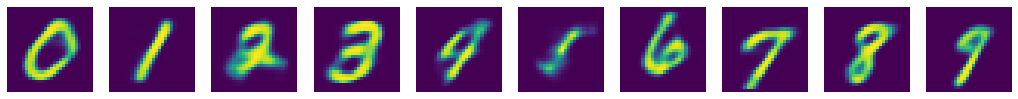

Epoch 25: loss 12413.830078125


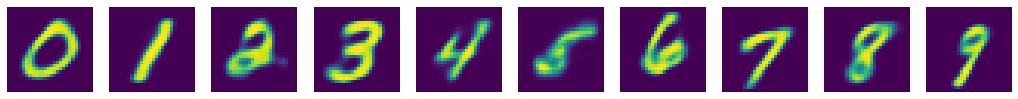

Epoch 30: loss 11545.943359375


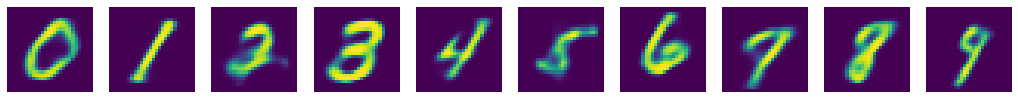

Epoch 35: loss 12124.3759765625


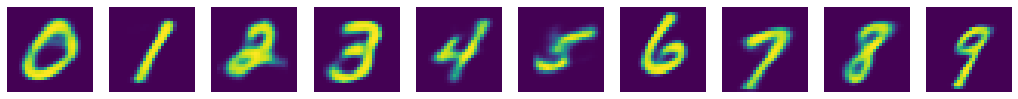

Epoch 40: loss 12504.5576171875


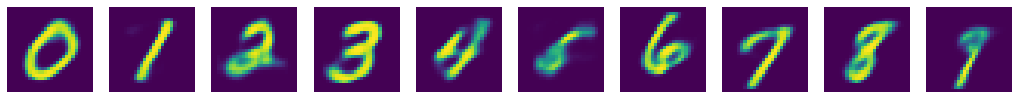

Epoch 45: loss 11508.759765625


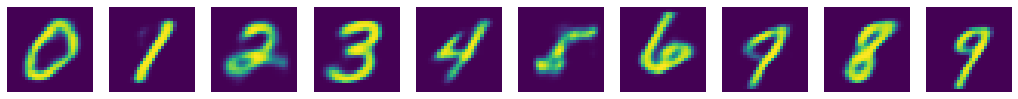

Epoch 50: loss 11991.775390625


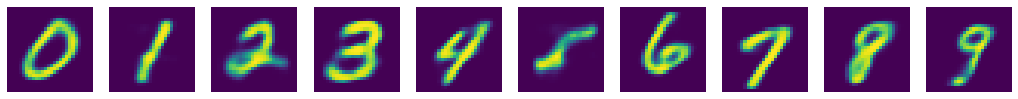

In [42]:
import matplotlib.pyplot as plt
import numpy

losses = []

for epoch in range(epochs):
    for idx, (real, _) in enumerate(dataloader):
        real = real.view(real.shape[0], input_dim)
        real.to(device)
        
        out, mean, std = vae(real)
        
        reconstruction_loss = criterion(out, real)
        kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2))
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().item())
    
    if epoch%5 == 0:
        print(f'Epoch {epoch}: loss {loss}')

        # visualize
        encodings_digit = []
        for d in range(10):
            with torch.no_grad():
                mean, std = vae.encode(images[d].view(1, input_dim))
            encodings_digit.append((mean, std))

        
        fig, axs = plt.subplots(1, 10, figsize=(18,5))
        for i in range(10):
            mean, std = encodings_digit[i]
            epsilon = torch.randn_like(std)
            z = mean + std * epsilon
            out = vae.decode(z)
            out = out.view(28, 28)
            data = out.cpu().detach().numpy()
            axs[i].imshow(data)
        for ax in axs:
            ax.axis('off')

        plt.show()
    

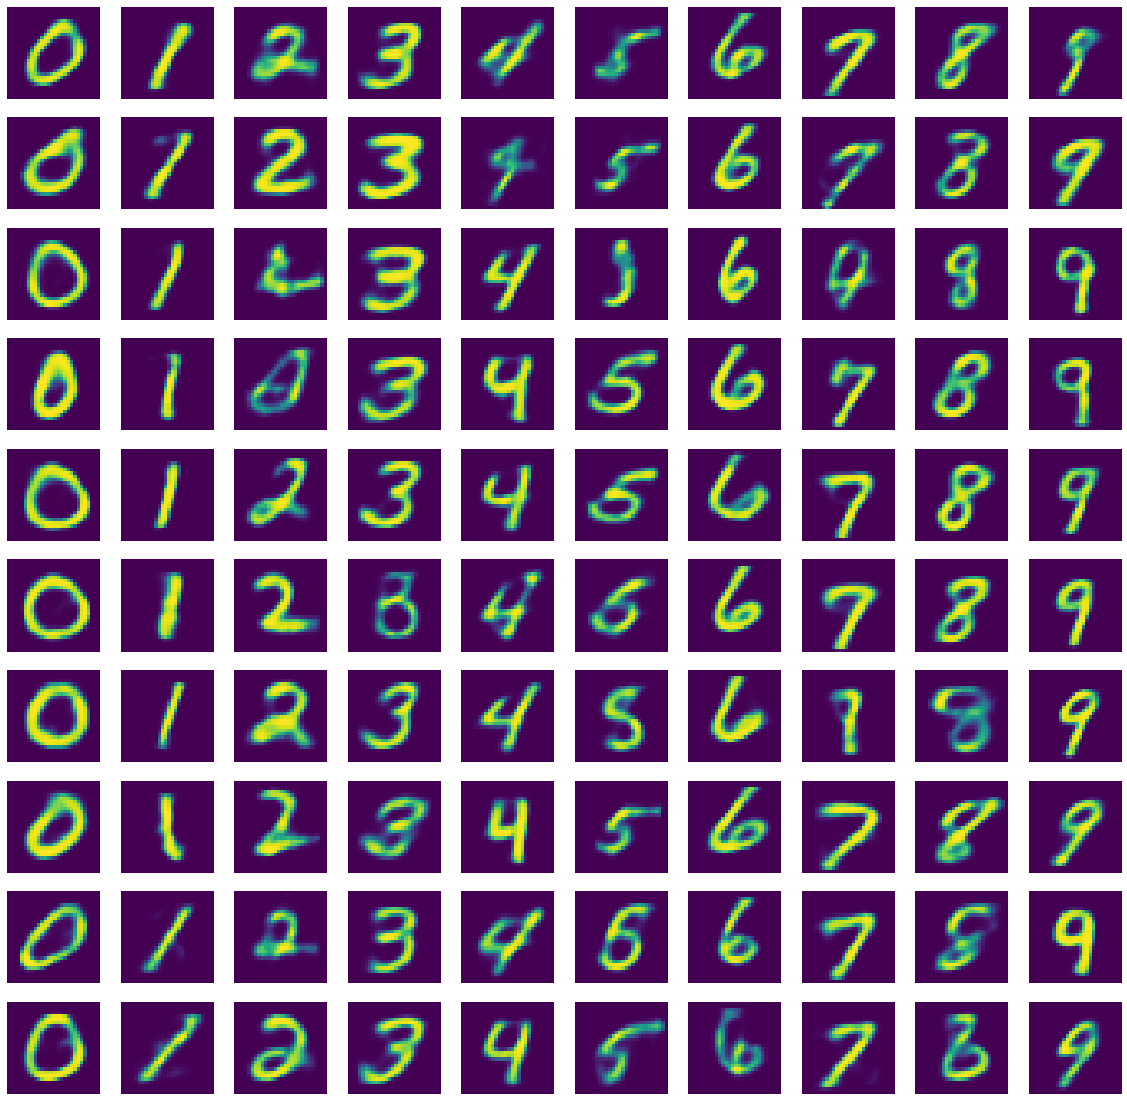

In [43]:
fig, axs = plt.subplots(10, 10, figsize=(20,20))
images = []
idx = 0
for x, y in dataset:
    if y == idx:
        images.append(x)
        idx += 1
    if idx == 10: idx=0
    if len(images) == 100: break

encodings_digit = []
for d in range(100):
    with torch.no_grad():
        mean, std = vae.encode(images[d].view(1, input_dim))
    encodings_digit.append((mean, std))

for i, ax in enumerate(axs.flat):
    mean, std = encodings_digit[i]
    epsilon = torch.randn_like(std)
    z = mean + std * epsilon
    out = vae.decode(z)
    out = out.view(28, 28)
    data = out.cpu().detach().numpy()
    ax.imshow(data)
    ax.axis('off')

plt.show()

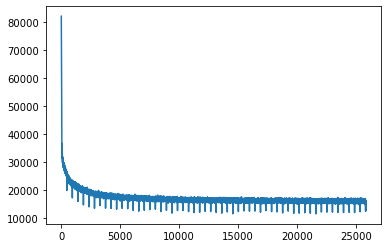

In [44]:
plt.figure()
plt.plot(losses[:])